Обрезка изображений с помощью Open CV

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from google.colab import drive
# Подключение Google Drive для загрузки модели
drive.mount('/content/drive')

# Путь к аннотационному файлу
#annotation_file = '/content/drive/My Drive/Colab Notebooks/less_face/annotations.csv'
#image_dir = '/content/drive/My Drive/Colab Notebooks/less_face'  # Путь к папке с изображениями


annotation_file = '/content/drive/My Drive/Colab Notebooks/more_face/annotations.csv'
image_dir = '/content/drive/My Drive/Colab Notebooks/more_face'  # Путь к папке с изображениями

# Загрузка аннотаций
annotations = pd.read_csv(annotation_file)

# Параметры
img_height, img_width = 32, 32
num_classes = annotations['feature'].nunique()

# Загрузка изображений и меток
images = []
labels = []

for _, row in annotations.iterrows():
    image_path = os.path.join(image_dir, row['filename'])
    image = cv2.imread(image_path)
    image = cv2.resize(image, (img_width, img_height))
    images.append(image)
    labels.append(row['feature'])


Mounted at /content/drive


Сохраняем обрезанные файлы

In [ ]:
# Преобразование данных в массивы NumPy
images = np.array(images, dtype=np.uint8)
labels = np.array(labels, dtype=np.int32)

# Сохранение данных
print("Сохранение обработанных данных...")
np.save(output_images_file, images)
np.save(output_labels_file, labels)
print(f"Данные сохранены: {output_images_file}, {output_labels_file}")

In [ ]:
# Перемещение файла с обработанными изображениями
!mv /content/processed_images.npy "/content/drive/My Drive/Colab Notebooks/resize_image/processed_images.npy"

# Перемещение файла с метками
!mv /content/labels.npy "/content/drive/My Drive/Colab Notebooks/resize_image/labels.npy"

mv: cannot stat '/content/processed_images.npy': No such file or directory
mv: cannot stat '/content/labels.npy': No such file or directory


Выгрузка обрезанных изображений

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np

# Пути к файлам
images_path = "/content/drive/My Drive/Colab Notebooks/resize_image/processed_images.npy"
labels_path = "/content/drive/My Drive/Colab Notebooks/resize_image/labels.npy"

# Загрузка данных
processed_images = np.load(images_path)
labels = np.load(labels_path)

# Проверка данных
print("Форма обработанных изображений:", processed_images.shape)
print("Форма меток:", labels.shape)


Форма обработанных изображений: (11586, 32, 32, 3)
Форма меток: (11586,)


Архитектура модели

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# Выгрузка данных
processed_images = np.load("/content/drive/My Drive/Colab Notebooks/resize_image/processed_images.npy")
labels = np.load("/content/drive/My Drive/Colab Notebooks/resize_image/labels.npy")

print(f"Форма изображений: {processed_images.shape}")
print(f"Форма меток: {labels.shape}")

# Преобразование меток в числовой формат и категориальные данные
labels = pd.factorize(labels)[0]  # Преобразуем строки в числа
num_classes = len(np.unique(labels))  # Определяем количество классов
labels = to_categorical(labels, num_classes)

x_train, x_test, y_train, y_test = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

print(f"Форма x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Форма x_test: {x_test.shape}, y_test: {y_test.shape}")

img_height, img_width = processed_images.shape[1], processed_images.shape[2]
inputs = layers.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall()])

model.summary()

Форма изображений: (11586, 32, 32, 3)
Форма меток: (11586,)
Форма x_train: (9268, 32, 32, 3), y_train: (9268, 6)
Форма x_test: (2318, 32, 32, 3), y_test: (2318, 6)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 10, 10, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 10, 10, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 10, 10, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 10, 64)     │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 10, 10, 64)     │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 10, 10, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 10, 10, 64)     │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ conv2d_6[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         16,640 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6)              │          1,542 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 222,214 (868.02 KB)

 Trainable params: 222,214 (868.02 KB)

 Non-trainable params: 0 (0.00 B)

Компиляция модели

In [ ]:
from tensorflow.keras.metrics import Recall

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall()])

Обучение модели без сохранением истории

In [ ]:
model.fit(x_train, y_train, batch_size=120, epochs=100, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Точность на тестовых данных:", test_accuracy)

sample_index = 5
plt.imshow(x_test[sample_index])
plt.title("Предсказание: " + str(np.argmax(model.predict(np.expand_dims(x_test[sample_index], axis=0)))))
plt.show()

Обучение модели с сохранением истории

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.2)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4863 - loss: 1.1990 - recall: 0.2964 - val_accuracy: 0.6294 - val_loss: 0.8941 - val_recall: 0.4466
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6288 - loss: 0.8749 - recall: 0.5063 - val_accuracy: 0.7988 - val_loss: 0.5088 - val_recall: 0.7470
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 79s 963ms/step - accuracy: 0.7950 - loss: 0.5465 - recall: 0.7461 - val_accuracy: 0.8560 - val_loss: 0.3818 - val_recall: 0.8161
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 54s 929ms/step - accuracy: 0.8536 - loss: 0.3906 - recall: 0.8224 - val_accuracy: 0.8900 - val_loss: 0.3164 - val_recall: 0.8711
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 966ms/step - accuracy: 0.8860 - loss: 0.3045 - recall: 0.8655 - val_accuracy: 0.8657 - val_loss: 0.3408 - val_recall: 0.8441
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 966ms/step - accuracy: 0.9001 - loss: 0.2722 - recall: 0.8845 - val_accuracy: 0.8932 - val_loss: 0.3261 - val_recall: 0.885

Сохранение истории

In [2]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/history/history.pkl', 'wb') as f:
    pickle.dump(history, f)

NameError: name 'history' is not defined

Загрузка истории обучения

In [1]:
import pickle

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/Colab Notebooks/history.pkl', 'rb') as f:
    history = pickle.load(f)

Mounted at /content/drive


Построение графиков

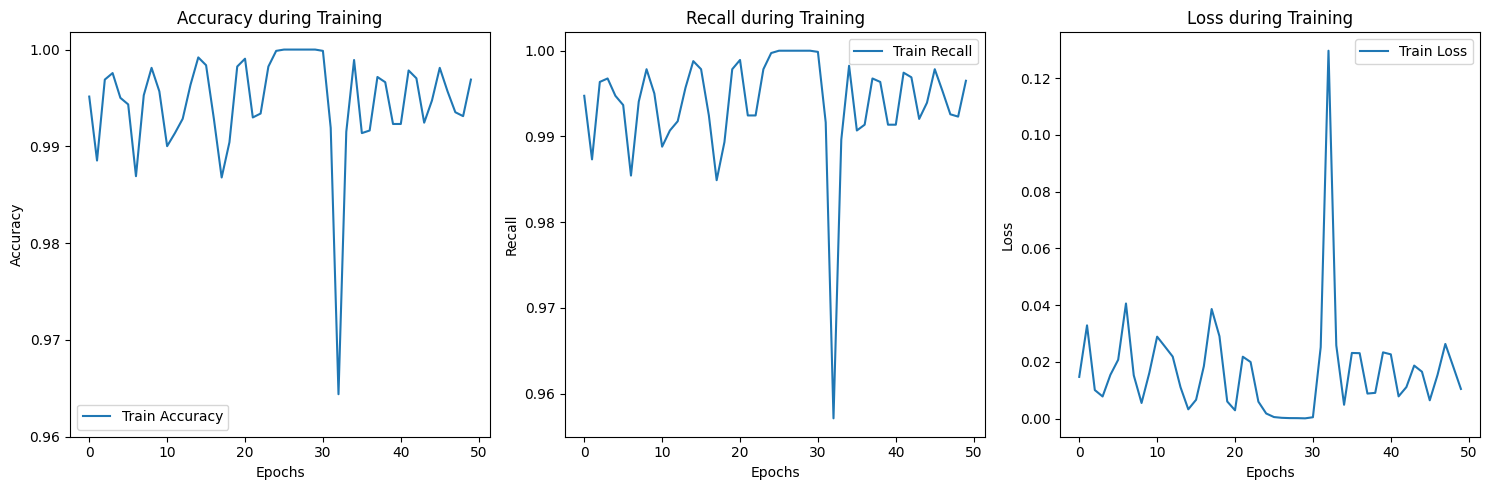

In [14]:
import matplotlib.pyplot as plt

# Построение графиков
plt.figure(figsize=(15, 5))

# График точности
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Устанавливаем 5 шкал на оси y
plt.yticks([round(i, 2) for i in np.linspace(min(history['accuracy']), max(history['accuracy']), 5)])

# График recall
plt.subplot(1, 3, 2)
plt.plot(history['recall'], label='Train Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall during Training')
plt.legend()

# График потерь
plt.subplot(1, 3, 3)
plt.plot(history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

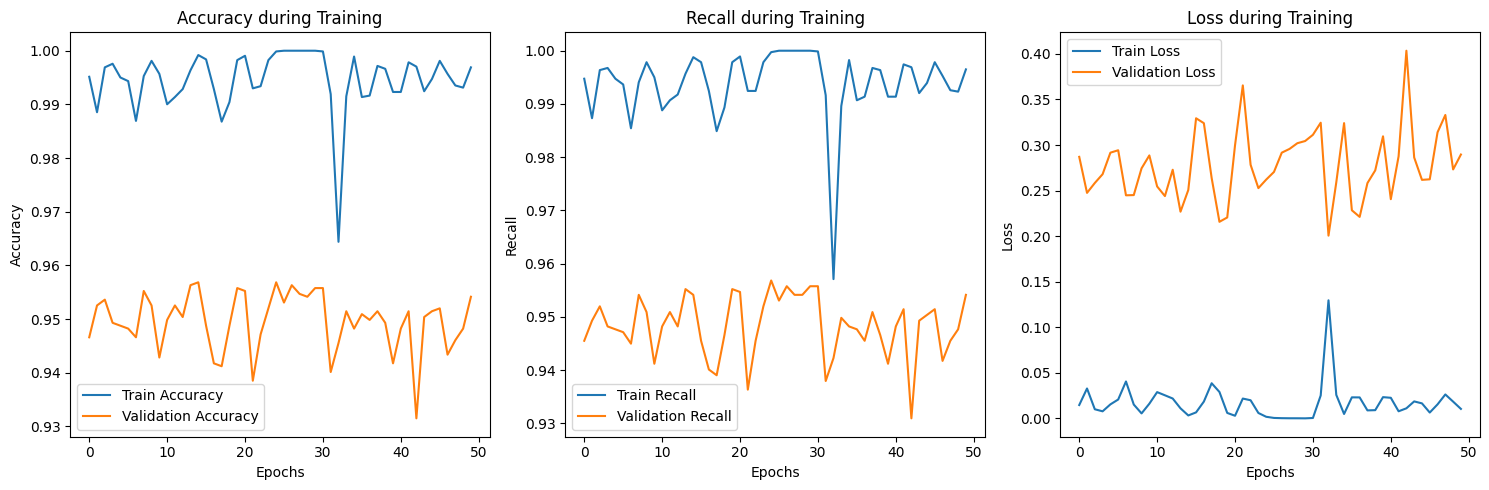

In [7]:
# Построение графиков
plt.figure(figsize=(15, 5))

# График точности
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# График recall
plt.subplot(1, 3, 2)
plt.plot(history['recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall during Training')
plt.legend()

# График потерь
plt.subplot(1, 3, 3)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/model_100_epoch.keras')

results = model.evaluate(x_test, y_test, verbose=1)

test_loss = results[0]
test_accuracy = results[1]
test_recall = results[2]

print(f"Точность на тестовых данных: {test_accuracy * 100:.2f}%")
print(f"Потери на тестовых данных: {test_loss:.4f}")
print(f"Recall на тестовых данных: {test_recall * 100:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9542 - loss: 0.2438 - recall: 0.9539
Точность на тестовых данных: 95.13%
Потери на тестовых данных: 0.2922
Recall на тестовых данных: 95.08%


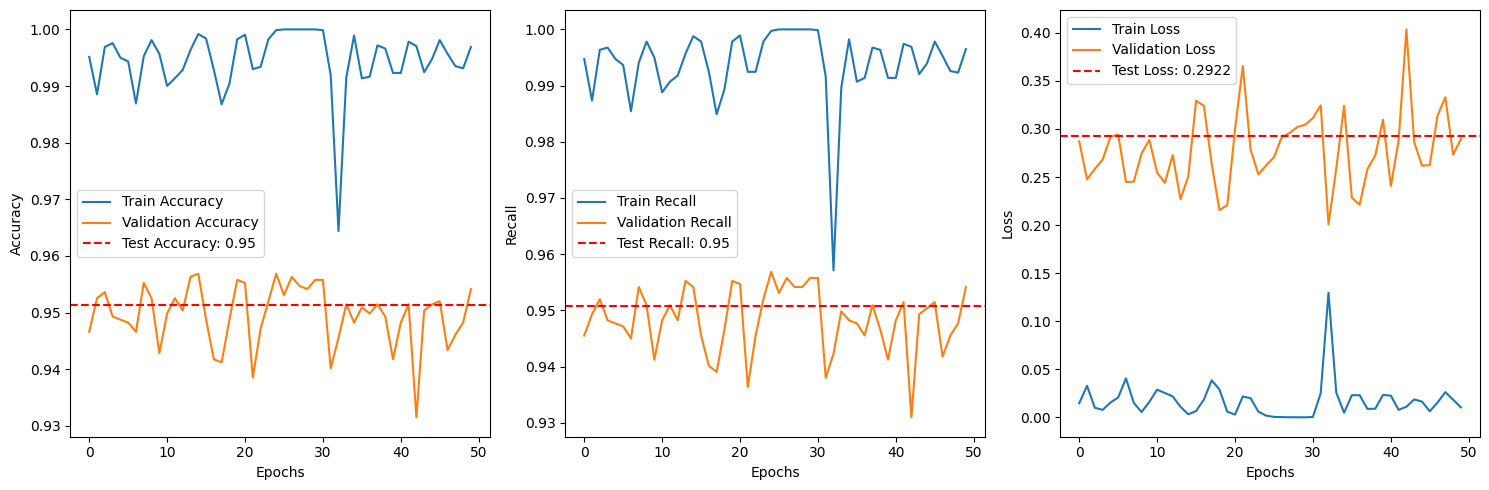

In [15]:
import matplotlib.pyplot as plt

# Точность, recall и потери на тестовых данных
test_loss = results[0]
test_accuracy = results[1]
test_recall = results[2]

# Построение графиков
plt.figure(figsize=(15, 5))

# График точности
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

# График recall
plt.subplot(1, 3, 2)
plt.plot(history['recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.axhline(y=test_recall, color='r', linestyle='--', label=f'Test Recall: {test_recall:.2f}')
plt.xlabel('Epochs')
plt.ylabel('Recall')

plt.legend()

# График потерь
plt.subplot(1, 3, 3)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

# Упорядочиваем графики
plt.tight_layout()
plt.show()

Сохранение модели

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/model_100_epoch.keras')

Выгрузка модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/model_100_epoch.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Примеры работы модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


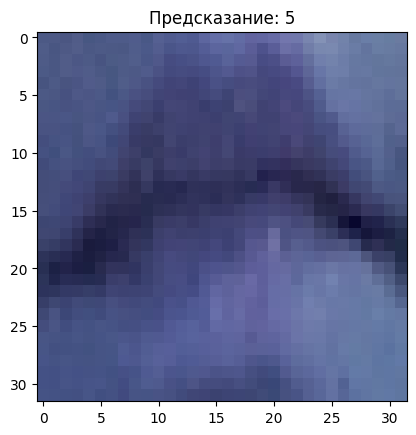

In [ ]:
sample_index = 399
plt.imshow(x_test[sample_index])
plt.title("Предсказание: " + str(np.argmax(model.predict(np.expand_dims(x_test[sample_index], axis=0)))))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


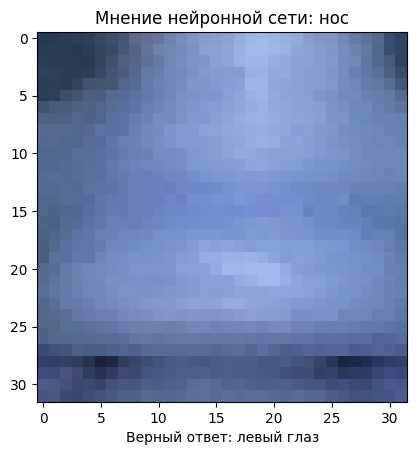

In [ ]:
I = 235
prediction = np.argmax(model.predict(x_test[I].reshape([1, 32, 32, 3])))
class_labels = ["глаз", "глаз", "бровь", "бровь", "нос", "рот"]
#class_labels = ["левый глаз", "правый глаз", "левая бровь", "правая бровь", "нос", "рот"]

plt.imshow(x_test[I].reshape([32, 32, 3]), cmap='gray')
plt.title(f"Мнение нейронной сети: {class_labels[prediction]}")
plt.xlabel(f"Верный ответ: {class_labels[int(y_test[I][0])]}")
plt.show()


---------------------------ДАЛЬШЕ БОГА НЕТ----------------------------------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
# Проверьте несколько значений y_test
for i in range(10):
    print(f"Index {i}: {y_test[i][0]}, class: {class_labels[int(y_test[i][0])]}")


Index 0: 0.0, class: глаз
Index 1: 0.0, class: глаз
Index 2: 0.0, class: глаз
Index 3: 1.0, class: глаз
Index 4: 0.0, class: глаз
Index 5: 0.0, class: глаз
Index 6: 1.0, class: глаз
Index 7: 0.0, class: глаз
Index 8: 0.0, class: глаз
Index 9: 0.0, class: глаз


In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))


{0.0: 2890, 1.0: 578}


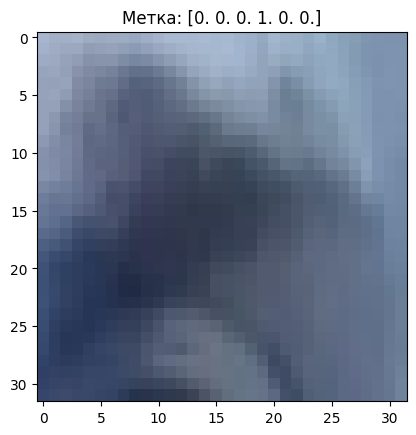

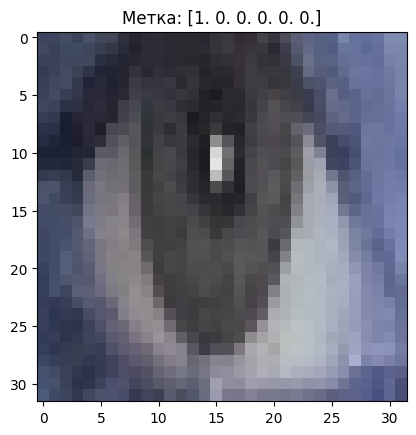

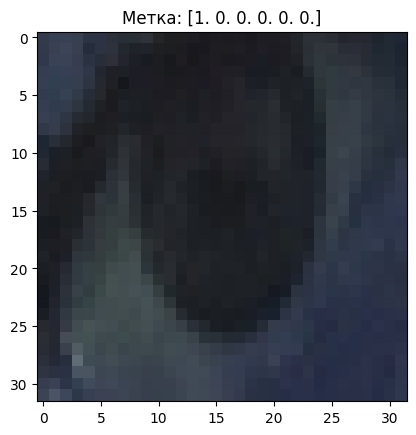

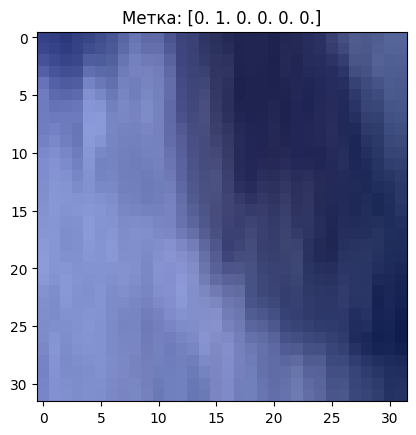

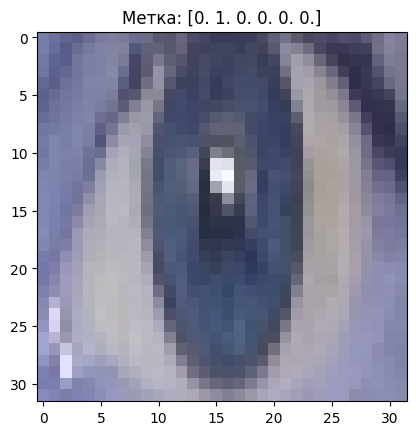

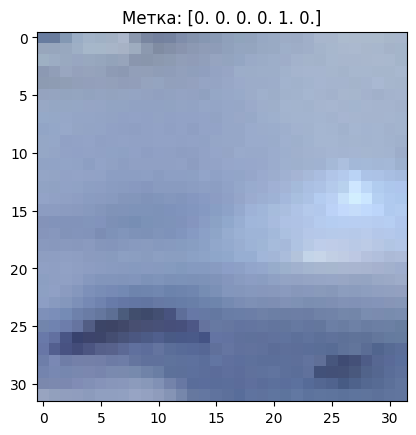

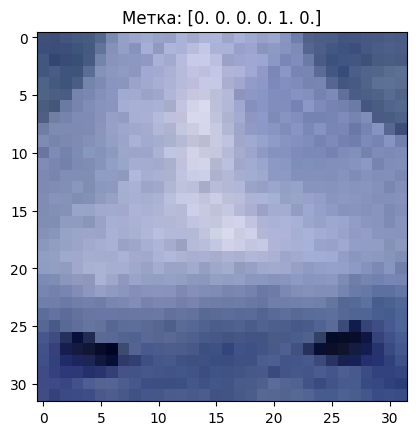

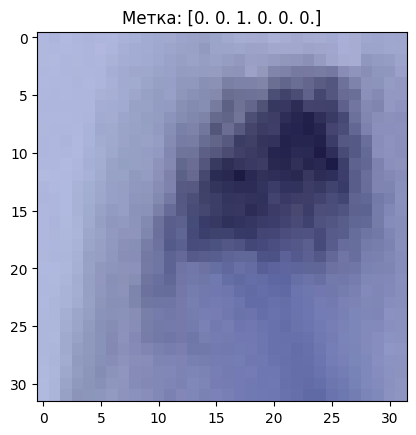

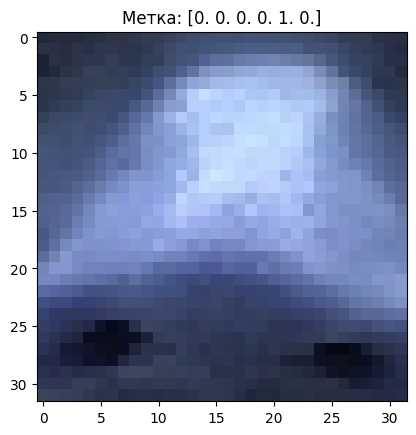

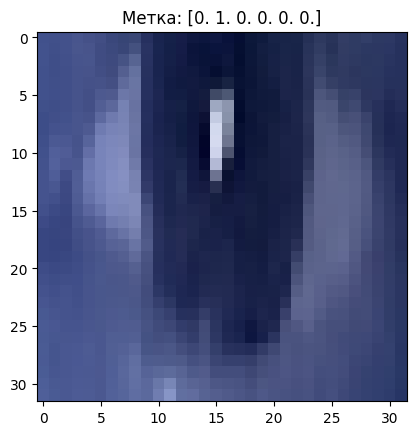

In [ ]:
import matplotlib.pyplot as plt

# Вывести несколько случайных изображений с метками
for i in range(10):
    index = np.random.randint(0, len(x_test))
    plt.imshow(x_test[index].reshape(32, 32, 3))
    plt.title(f"Метка: {y_test[index]}")
    plt.show()


In [ ]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Train set distribution:", dict(zip(unique_train, counts_train)))
print("Test set distribution:", dict(zip(unique_test, counts_test)))


Train set distribution: {0.0: 11540, 1.0: 2308}
Test set distribution: {0.0: 2890, 1.0: 578}


In [ ]:
import pandas as pd

from google.colab import drive
# Подключение Google Drive для загрузки модели
drive.mount('/content/drive')

# Загрузка CSV и проверка распределения классов
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/less_face/annotations.csv")
print(data['feature'].value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
feature
left_eye         481
right_eye        481
left_eyebrow     481
right_eyebrow    481
nose             481
mouth            481
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(data['feature'])
print("Encoded classes:", encoder.classes_)


Encoded classes: ['left_eye' 'left_eyebrow' 'mouth' 'nose' 'right_eye' 'right_eyebrow']


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(data['filename'], y_encoded, test_size=0.2, random_state=42)

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Train set distribution:", dict(zip(unique_train, counts_train)))
print("Test set distribution:", dict(zip(unique_test, counts_test)))


Train set distribution: {0: 389, 1: 391, 2: 383, 3: 395, 4: 372, 5: 378}
Test set distribution: {0: 92, 1: 90, 2: 98, 3: 86, 4: 109, 5: 103}


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/mega_face_analys.keras')

In [ ]:
from tensorflow.keras.models import load_model

from google.colab import drive
drive.mount('/content/drive')

model = load_model('/content/drive/My Drive/Colab Notebooks/face_analys.keras')


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
!pip install requests Pillow

In [ ]:
import requests
from PIL import Image
import numpy as np
import io

In [ ]:
def load_and_preprocess_image(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))

    image = image.resize((32, 32))

    image_array = np.array(image) / 255.0

    image_array = np.expand_dims(image_array, axis=0)

    return image_array


In [ ]:
class_labels = ["правый глаз", " левый глаз", "правая бровь", "левая бровь", "нос", "рот"]

In [ ]:
url = 'https://images.unsplash.com/photo-1583164074947-4de362fd915f?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NjAwfHxleWV8ZW58MHx8MHx8fDA%3D'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")
#plt.title("Предсказание: " + str(np.argmax(model.predict(np.expand_dims(x_test[sample_index], axis=0)))))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class: левый глаз


In [ ]:
url = 'https://images.unsplash.com/photo-1612399074639-502e40df7971?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Njg1fHxleWV8ZW58MHx8MHx8fDA%3D'
preprocessed_image = load_and_preprocess_image(url)


prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class: глаз


In [ ]:
url = 'https://images.unsplash.com/photo-1517920366573-9d35a519b7c2?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NDJ8fGV5ZXxlbnwwfHwwfHx8MA%3D%3D'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: глаз


In [ ]:
url = 'https://images.unsplash.com/photo-1617339860632-f53c5b5dce4d?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Nzl8fGV5ZXxlbnwwfHwwfHx8MA%3D%3D'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: глаз


In [ ]:
url = 'https://images.unsplash.com/photo-1612399074639-502e40df7971?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Njg1fHxleWV8ZW58MHx8MHx8fDA%3D'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: глаз


In [ ]:
url = 'https://images.pexels.com/photos/7480264/pexels-photo-7480264.jpeg?auto=compress&cs=tinysrgb&w=600'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: бровь


In [ ]:
url = 'https://images.pexels.com/photos/7480264/pexels-photo-7480264.jpeg?auto=compress&cs=tinysrgb&w=600'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


NameError: name 'class_labels' is not defined

In [ ]:
url = 'https://images.pexels.com/photos/3507181/pexels-photo-3507181.jpeg?auto=compress&cs=tinysrgb&w=600'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class: бровь


In [ ]:
url = 'https://images.pexels.com/photos/9409695/pexels-photo-9409695.jpeg?auto=compress&cs=tinysrgb&w=600'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: бровь


In [ ]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQmCKwishXbPW48qWaE2lHvWd5Ysa2fYid7jdsYkEWTpJAh_V0RCjlXge13PRl8ht-Q03U&usqp=CAU'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: нос


In [ ]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBIXInp5q78u-OzhR3n4AeKtGH3EEAEFdHY7z0bITcLUSBNSSIGUEuEaO5w1ON9rui8ao&usqp=CAU'
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: нос


In [ ]:
url = 'https://media.istockphoto.com/id/469346982/photo/close-up-still-life-of-womans-nose.jpg?s=612x612&w=0&k=20&c=JQkcU-0m7s_5El1AJXUhdBhdf1Zi2SXhSWQUx4LGglA='
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: нос


In [ ]:
url = 'https://media.istockphoto.com/id/469346982/fi/valokuva/naisen-nen%C3%A4n-l%C3%A4hi-aikominen.jpg?s=612x612&w=0&k=20&c=5lWd2fJeczUoMfX6mdzaKErmwHuizWnzJ0caSRbSzss='
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: нос


In [ ]:
url = 'https://media.istockphoto.com/id/2128187248/fi/valokuva/emax-keraamiset-kruunut-hampaissa-ja-implantteissa.jpg?s=612x612&w=0&k=20&c=nXC9lv0pJjYs-0x6hn2PS56bqxOXu9a4xjymfzU5adI='
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: рот


In [ ]:
url = 'https://media.istockphoto.com/id/1491877452/fi/valokuva/nainen-n%C3%A4ytt%C3%A4%C3%A4-sairaan-kielen-jossa-on-hampaiden-j%C3%A4lki%C3%A4-ja-valkoinen-plakki-l%C3%A4hikuvassa.jpg?s=612x612&w=0&k=20&c=a0OfezRBdqOpmyh5qClC5yjkD_G6TYgubL5s7KEsaVE='
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: рот


In [ ]:
url = 'https://media.istockphoto.com/id/2167463346/fi/valokuva/mies-n%C3%A4ytt%C3%A4%C3%A4-kaksi-etuhampaansa-jotka-ovat-lohkeilleet.jpg?s=612x612&w=0&k=20&c=IfrjbINksQwOpVB1HXzeDuhGTwnqA23y8_wxJIB6-9I='
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: рот


In [ ]:
url = 'https://media.gettyimages.com/id/135328786/photo/body-parts.jpg?s=612x612&w=0&k=20&c=xVnXkYfmFaYJhNM1EgJ7qpxCfy37UIdjMn36grH6rzE='
preprocessed_image = load_and_preprocess_image(url)

prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: рот


NameError: name 'history' is not defined

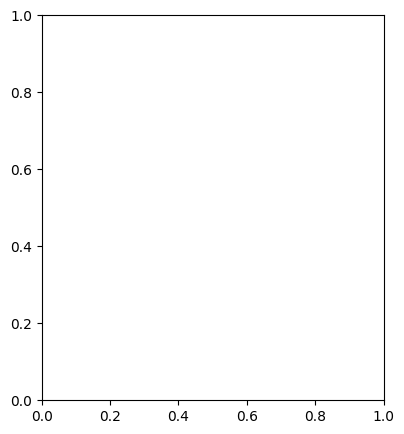

In [ ]:
import matplotlib.pyplot as plt

# Предположим, что ваша модель обучена и переменная `history` содержит историю обучения
# Например: history = model.fit(...)

# Построение графика точности
plt.figure(figsize=(15, 5))

# График точности (Accuracy)
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# График полноты (Recall)
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall during Training')
plt.legend()

# График потерь (Loss)
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(data['filename'], y_encoded, test_size=0.2, random_state=42)

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Train set distribution:", dict(zip(unique_train, counts_train)))
print("Test set distribution:", dict(zip(unique_test, counts_test)))

Train set distribution: {0: 389, 1: 391, 2: 383, 3: 395, 4: 372, 5: 378}
Test set distribution: {0: 92, 1: 90, 2: 98, 3: 86, 4: 109, 5: 103}

In [ ]:
в нашем коде проверка на проходит на тренировочных данных?